In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupKFold

from sklearn.metrics import make_scorer
from sklearn.cross_validation import LabelKFold
from ml_metrics import rmsle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

/Users/alexguanga/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def correlation_values(data, target, pred_series=None, include_pred=False):
    if include_pred is True:
        data[target] = pred_series
    
    corr_matrix = data.corr()
    top_corr = list(corr_matrix[target].sort_values(ascending=False).index)
    corr_values = corr_matrix[target].sort_values(ascending=False)
    return pd.DataFrame(corr_values, index=top_corr)

def remove_unwanted_vars(data, unwanted_list):
    feats = [feat for feat in data.columns if feat not in unwanted_list]
    return feats

def create_dummies(data, dummy_list):
    return pd.get_dummies(data, columns=dummy_list, drop_first=True)

def get_Xs_y(data, target, remove_more=None):
    if remove_more is not None:
        Xs = [feat for feat in data.columns if feat not in remove_more]
    else:
        Xs = [feat for feat in data.columns if feat not in target]

    return [data[Xs].values, data[target].values]

def get_important_features(data, model, target, unwanted_feats, limit=10):
    Xs, y = get_Xs_y(data, target, unwanted_feats)
    col_names = remove_unwanted_vars(data, unwanted_feats)
    
    model.fit(Xs, y)
    best_features = pd.DataFrame(model.feature_importances_, index=data[col_names].columns)
    best_features = best_features.sort_values(by=[0], ascending=False)[:limit]
    return best_features.rename(columns={0:'name'})

def transform_label_nums(data, categorical_label):
    le = LabelEncoder()
    num_cols = le.fit_transform(data[categorical_label])
    return num_cols

def less_than_x_ctgy(data, treshold=10):
    categories = training_set.apply(lambda x: len(x.unique())).sort_values(ascending=True)
    categories_values, categories_labels = categories.values, categories.index
    categories_values = [ctgy for ctgy in categories_values if ctgy <= treshold]
    categories_labels =  categories_labels[:len(categories_values)]
    return pd.DataFrame(categories_values, index=categories_labels)

def matched_list(data, filter_like_list):
    return [col for col in data.columns for filter_col in filter_like_list if filter_col in col]


In [3]:
# Importing the datasets that will be used

training_set = pd.read_csv("./archive/train.csv")
testing_set = pd.read_csv("./archive/test.csv")

In [4]:
training_set.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

In [5]:
training_set.apply(lambda x: len(x.unique())).sort_values(ascending=False)

datetime      10886
count           822
registered      731
casual          309
humidity         89
atemp            60
temp             49
windspeed        28
weather           4
season            4
workingday        2
holiday           2
dtype: int64

In [6]:
training_set.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


### Feature Engineering

In [7]:
# Noticed that we have date that can be parsed in many ways
training_set['datetime'] = pd.to_datetime(training_set['datetime'])

training_set['year'] = training_set['datetime'].dt.year
training_set['month'] = training_set['datetime'].dt.month
training_set['day'] = training_set['datetime'].dt.day
training_set['hour'] = training_set['datetime'].dt.hour
training_set['minute'] = training_set['datetime'].dt.minute
training_set['dayofweek'] = training_set['datetime'].dt.dayofweek
training_set['weekofyear'] = training_set['datetime'].dt.weekofyear

training_set['weekend'] = training_set['dayofweek'].map(lambda x: int(x in [5,6]))

# Creating a column that labels the winner of the game

# Conditional on time of day, morning=1, afternoon=2, evening=3, night=4
conditions = [
    ((training_set['hour'] >=  5) & (training_set['hour'] < 12)),
    ((training_set['hour'] >=  12) & (training_set['hour'] < 17)),
    ((training_set['hour'] >=  17) & (training_set['hour'] < 21))
]
choices = [1, 2, 3]
training_set['time_of_day'] = np.select(conditions, choices, default=4)

training_set['rush_hour'] = training_set['hour'].apply(lambda x: int(x in [8,9,10,17,18,19]))
training_set['rush_workday'] = 0
training_set.loc[training_set['weekend'] == 0, 'rush_workday'] = 1

training_set['holiday'] = training_set[['month', 'day', 'holiday', 'year']].apply(
    lambda x: (x['holiday'], 1)[x['year'] == 2012 and x['month'] == 10 and (x['day'] in [30])], axis = 1)

training_set['holiday'] = training_set[['month', 'day', 'holiday']].apply(
    lambda x: (x['holiday'], 1)[x['month'] == 12 and (x['day'] in [24, 26, 31])], axis = 1)

/Users/alexguanga/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/Users/alexguanga/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


In [8]:
training_set['time_of_day'] = transform_label_nums(training_set, 'time_of_day')
rf_feats = get_important_features(training_set, RandomForestRegressor(), 'count', 
                       ['registered', 'casual', 'count', 'datetime'], 15)
rf_feats

,name
hour,0.493003
year,0.087061
temp,0.071772
workingday,0.055545
rush_hour,0.054193
time_of_day,0.053669
atemp,0.035226
humidity,0.027560
weekofyear,0.025640
dayofweek,0.025452


In [9]:
cleaned_vars = remove_unwanted_vars(training_set, ['registered', 'casual'])
corr_feats = correlation_values(training_set[cleaned_vars], 'count')
corr_feats

,count
count,1.000000
rush_hour,0.439820
hour,0.400601
temp,0.394454
atemp,0.389784
year,0.260403
month,0.166862
season,0.163439
weekofyear,0.152512
windspeed,0.101369


- Using the Random Forest best features parameter & the correlation matrix:
    - Top values to look at are hour, temp, time_of_day (neg correlation), humidity, workingday, atemp

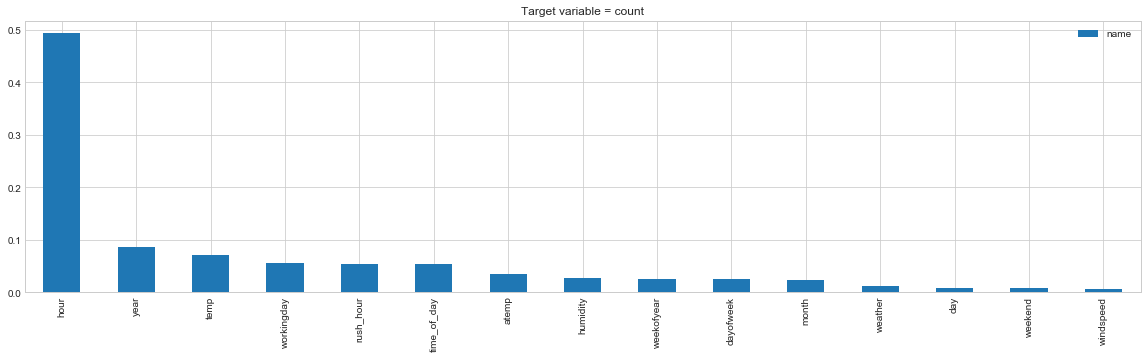

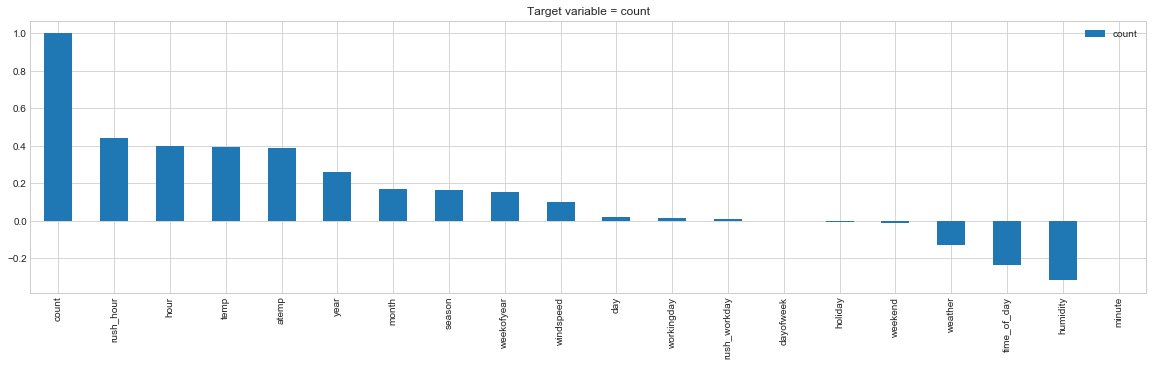

In [10]:
# Visuals for correlation and Random Forest features
rf_feats.plot(kind='bar', figsize=(20, 5), title="Target variable = {0}".format('count'))
corr_feats.plot(kind='bar', figsize=(20, 5), title="Target variable = {0}".format('count'))

In [11]:
# The minute variable does not provide any value

training_set.drop(['minute'], axis=1, inplace=True)

In [12]:
# What are the unique values? Need to transform some of these variables to dummies

dummy_list = less_than_x_ctgy(training_set, treshold=10).index.tolist()
training_set_w_dummies = create_dummies(training_set, dummy_list)
training_set_w_dummies.drop('datetime', axis=1, inplace=True)

In [13]:
# Understanding the added dummy variables to the training set

training_set_w_dummies.shape        

(10886, 32)

### Advanced Feature Enginnering

In [27]:
def feats_by_variance(data, ylabel, remove_more_xs=None, threshold=.6):
    if remove_more_xs is not None: ylabel = ylabel + remove_more_xs

    feats = remove_unwanted_vars(data, [ylabel, 'registered', 'casual', 'datetime'])
    sel = VarianceThreshold(threshold=(threshold * (1 - threshold)))
    sel.fit_transform(data[feats], data[ylabel]).shape

    current_feats = np.array(feats)[sel.get_support()]
    to_remove_feats = list(set(np.array(feats)) - set(current_feats))

    print("removed features: {0}\n\ncurrent features: {1}".format(to_remove_feats, current_feats))

In [28]:
feats_by_variance(training_set, 'count')

removed features: ['weekend', 'rush_hour', 'workingday', 'rush_workday', 'holiday']

current features: ['season' 'weather' 'temp' 'atemp' 'humidity' 'windspeed' 'year' 'month'
 'day' 'hour' 'dayofweek' 'weekofyear' 'time_of_day']


In [ ]:
# Checking the variance in the cleaned training set without the dummy variables

feats = remove_unwanted_vars(training_set, ['count', 'registered', 'casual', 'datetime'])
treshold = .6
sel = VarianceThreshold(threshold=(treshold * (1 - treshold)))
sel.fit_transform(training_set[feats], training_set['count']).shape

current_feats = np.array(feats)[sel.get_support()]
removed_feats = list(set(np.array(feats)) - set(current_feats))

print("removed features: {0}\n\ncurrent features{1}".format(removed_feats, current_feats))

In [74]:
def modeling(model, data, feats, target, n_folds=3):
    Xs, y  = data[feats].values, data[target].values
    groups = data['datetime'].dt.month.values
    group_kfold = GroupKFold(n_splits=n_folds)
    
    scores = []
    for train_idx, test_idx in group_kfold.split(Xs, y, groups):
        model.fit(Xs[train_idx], y[train_idx])
        y_pred = model.predict(Xs[test_idx])
        y_pred[y_pred <0 ] = 0
        scores.append(rmsle(y[test_idx], y_pred))
    
    return np.mean(scores), np.std(scores)


def find_the_best_features(data, sel_class, model, target, verbose=True, range_k = range(2, 16), show_top=5):
    feats = remove_unwanted_vars(data, ['count', 'registered', 'casual', 'datetime'])
    X,y = data[feats], data[target]

    results = []
    for k in range_k:
        sel = sel_class(k)
        X_new = sel.fit_transform(X, y)

        current_feats = np.array(feats)[sel.get_support()]
        mean_score, std_score = modeling(model, data, current_feats, target)
        mean_score, std_score = np.abs(mean_score), np.abs(std_score)
        if verbose:
            print("score={0}, std-score{1}, features#{2}: {3}".format(round(mean_score, 5), round(std_score, 4), len(current_feats), current_feats ))
        
        results.append((mean_score, std_score, current_feats))
    return sorted(results, key=lambda x: x[0])[:show_top]

In [79]:
# Training across different models to find the best features selections

models = [ 
    ('extra_tree', ExtraTreesRegressor()),
    ('random_forest', RandomForestRegressor()),
    ('ada boost', AdaBoostRegressor()),
    ('decision tree', DecisionTreeRegressor()),
    ('xgb_model', xgb.XGBRegressor())
]

poss_targets = ['count', 'registered', 'casual']     
        
for target in poss_targets:
    print("Target Variable: {0}".format(target))
    
    for model_name, model in models:
        print("Model: {0}".format(model_name))
        try:
            results = find_the_best_features(training_set, lambda k: RFE(model, k, step=1), 
                                             model, target, verbose=False)
        except RuntimeError:
            results = find_the_best_features(training_set, lambda k: SelectKBest(chi2, k), 
                                             model, target, verbose=False)
        best_features = results[0][2]        
        mean_score, std_score = modeling(model, training_set, best_features, target)
        mean_score, std_score = np.abs(mean_score), np.abs(std_score)
        print("{0} are the best features with a mean score of: {1}\n".format(best_features, mean_score))

    print('\n----------------------------------\n')


Target Variable: count
Model: extra_tree
['season' 'workingday' 'weather' 'temp' 'atemp' 'humidity' 'year' 'month'
 'hour' 'dayofweek' 'weekofyear' 'weekend' 'time_of_day' 'rush_hour'] are the best features with a mean score of: 0.38370507035829154

Model: random_forest
['workingday' 'weather' 'temp' 'atemp' 'humidity' 'year' 'month' 'hour'
 'dayofweek' 'weekofyear' 'time_of_day' 'rush_hour' 'rush_workday'] are the best features with a mean score of: 0.3912857336535484

Model: ada boost
['year' 'hour'] are the best features with a mean score of: 0.8981668437720208

Model: decision tree
['workingday' 'weather' 'temp' 'atemp' 'humidity' 'year' 'month' 'hour'
 'dayofweek' 'weekofyear' 'rush_hour'] are the best features with a mean score of: 0.5047291325134392

Model: xgb_model
['workingday' 'temp' 'atemp' 'humidity' 'year' 'month' 'hour' 'dayofweek'
 'time_of_day' 'rush_hour'] are the best features with a mean score of: 0.6503063365802585


----------------------------------

Target Varia